# Chapter 6. Mixture Models

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import random, vmap, local_device_count, pmap, lax, tree_map
from jax import nn as jnn
from jax.scipy import stats, special

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.distributions.transforms import OrderedTransform

seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system
numpyro.set_host_device_count(local_device_count())

In [2]:
# import pymc3 as pm
# import numpy as np
# import scipy.stats as stats
# import pandas as pd
# import theano.tensor as tt
# import matplotlib.pyplot as plt
# import arviz as az

In [3]:
# az.style.use('arviz-darkgrid')

In [4]:
# np.random.seed(42)

([], [])

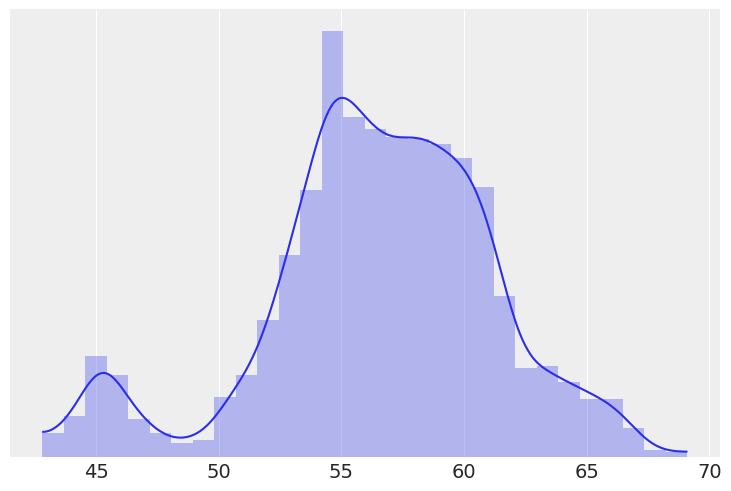

In [5]:
cs = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']
az.plot_kde(cs_exp)
plt.hist(cs_exp, density=True, bins=30, alpha=0.3)
plt.yticks([])

In [6]:
#with pm.Model() as model_kg:
#    p = pm.Dirichlet('p', a=np.ones(clusters))
#    z = pm.Categorical('z', p=p, shape=len(cs_exp))
#    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
#    sd = pm.HalfNormal('sd', sd=10)
#
#    y = pm.Normal('y', mu=means[z], sd=sd, observed=cs_exp)
#    trace_kg = pm.sample()

In [8]:
# with numpyro.handlers.seed(rng_seed=seed):
#     N = 1  # Samples
#     b = numpyro.sample("p", dist.Dirichlet(concentration=jnp.ones(clusters)).expand([N]))
# # dist.Dirichlet(concentration=jnp.ones(clusters)).sample(random.PRNGKey(0), (1,))

In [9]:
# b.squeeze()

In [10]:
clusters = 2

def model(obs=None):
    p = numpyro.sample("p", dist.Dirichlet(concentration=jnp.ones(clusters)))
    c = dist.Categorical(probs=p.squeeze())

    means = numpyro.sample('means', dist.Normal(loc=cs_exp.mean(), scale=10), sample_shape=(clusters,))
    sd = numpyro.sample('sd', dist.HalfNormal(scale=10))
    component_dist = dist.Normal(loc=means, scale=sd)
    
    y = numpyro.sample('y', dist.MixtureSameFamily(mixing_distribution=c, component_distribution=component_dist), obs=obs)
    
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
mcmc.run(random.PRNGKey(seed), obs=jnp.asarray(cs_exp))

sample: 100%|███████████████████████████████████████████| 2500/2500 [00:01<00:00, 1701.92it/s, 7 steps of size 6.96e-01. acc. prob=0.90]


In [11]:
mcmc.get_samples()

{'means': DeviceArray([[46.59215 , 57.53969 ],
              [46.77208 , 57.60634 ],
              [47.404488, 57.47748 ],
              ...,
              [57.420513, 47.251415],
              [57.43893 , 47.13221 ],
              [57.534637, 46.69333 ]], dtype=float32),
 'p': DeviceArray([[0.07781173, 0.9221883 ],
              [0.07711639, 0.9228836 ],
              [0.11415413, 0.8858459 ],
              ...,
              [0.90347517, 0.09652483],
              [0.8928458 , 0.10715419],
              [0.9177794 , 0.08222061]], dtype=float32),
 'sd': DeviceArray([3.6385975, 3.6188638, 3.5631063, ..., 3.6311502, 3.6953619,
              3.5244987], dtype=float32)}

array([[<AxesSubplot:title={'center':'means\n0'}>,
        <AxesSubplot:title={'center':'means\n0'}>],
       [<AxesSubplot:title={'center':'means\n1'}>,
        <AxesSubplot:title={'center':'means\n1'}>],
       [<AxesSubplot:title={'center':'p\n0'}>,
        <AxesSubplot:title={'center':'p\n0'}>],
       [<AxesSubplot:title={'center':'p\n1'}>,
        <AxesSubplot:title={'center':'p\n1'}>]], dtype=object)

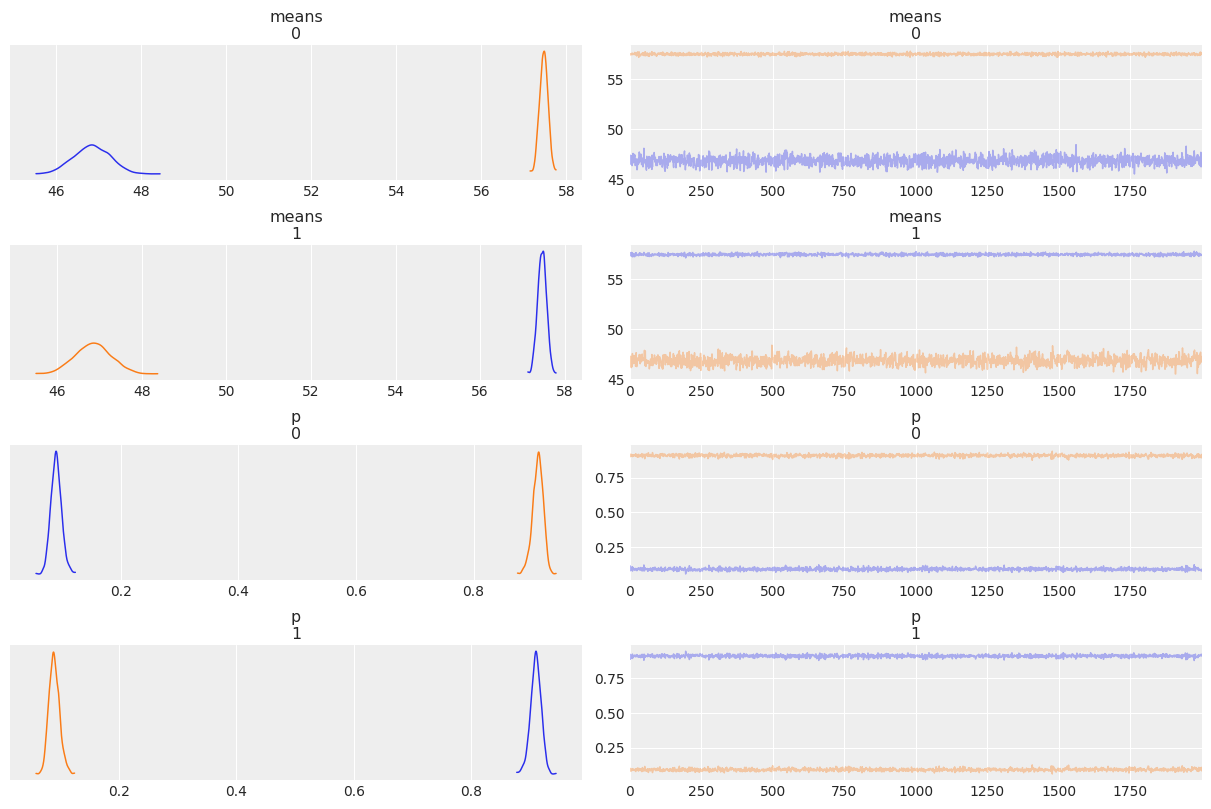

In [12]:
varnames = ['means', 'p']
az.plot_trace(mcmc, varnames, compact=False)

In [13]:
# clusters = 2
# with pm.Model() as model_mg:
#     p = pm.Dirichlet('p', a=np.ones(clusters))
#     means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
#     sd = pm.HalfNormal('sd', sd=10)
#     y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
#     trace_mg = pm.sample(random_seed=123)

In [14]:
# varnames = ['means', 'p']
# az.plot_trace(trace_mg, varnames)
# plt.savefig('B11197_06_06.png')

In [15]:
az.summary(mcmc, var_names=varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],52.154,5.324,46.283,57.672,3.752,3.176,3.0,55.0,1.83
means[1],52.156,5.316,46.310,57.674,3.746,3.171,3.0,58.0,1.83
p[0],0.500,0.410,0.078,0.924,0.289,0.245,3.0,51.0,1.83
p[1],0.500,0.410,0.076,0.922,0.289,0.245,3.0,51.0,1.83


In [17]:
# az.summary(trace_mg, varnames)

## Non-identifiability of mixture models

In [18]:
jnp.array([.9, 1]) * cs_exp.mean()

DeviceArray([50.859257, 56.51029 ], dtype=float32)

In [19]:
jnp.expand_dims(jnp.asarray(cs_exp), axis=1).shape

(1776, 1)

In [20]:
clusters = 2

def model(obs=None):
    p = numpyro.sample("p", dist.Dirichlet(concentration=jnp.ones(clusters)))
    c = dist.Categorical(probs=p.squeeze())
    
    mu = jnp.array([.9, 1]) * cs_exp.mean()

    means = numpyro.sample('means', dist.Normal(loc=mu, scale=10), sample_shape=(2,))
    sd = numpyro.sample('sd', dist.HalfNormal(scale=10))
    component_dist = dist.Normal(loc=means, scale=sd)
    
    y = numpyro.sample('y', dist.MixtureSameFamily(mixing_distribution=c, component_distribution=component_dist), obs=obs)
    
kernel = NUTS(model)
mcmc2 = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
mcmc2.run(random.PRNGKey(seed), obs=jnp.expand_dims(jnp.asarray(cs_exp), axis=1))

sample: 100%|████████████████████████████████████████████| 2500/2500 [00:02<00:00, 835.65it/s, 3 steps of size 7.73e-01. acc. prob=0.86]


array([[<AxesSubplot:title={'center':'means\n0, 0'}>,
        <AxesSubplot:title={'center':'means\n0, 0'}>],
       [<AxesSubplot:title={'center':'means\n0, 1'}>,
        <AxesSubplot:title={'center':'means\n0, 1'}>],
       [<AxesSubplot:title={'center':'means\n1, 0'}>,
        <AxesSubplot:title={'center':'means\n1, 0'}>],
       [<AxesSubplot:title={'center':'means\n1, 1'}>,
        <AxesSubplot:title={'center':'means\n1, 1'}>],
       [<AxesSubplot:title={'center':'p\n0'}>,
        <AxesSubplot:title={'center':'p\n0'}>],
       [<AxesSubplot:title={'center':'p\n1'}>,
        <AxesSubplot:title={'center':'p\n1'}>]], dtype=object)

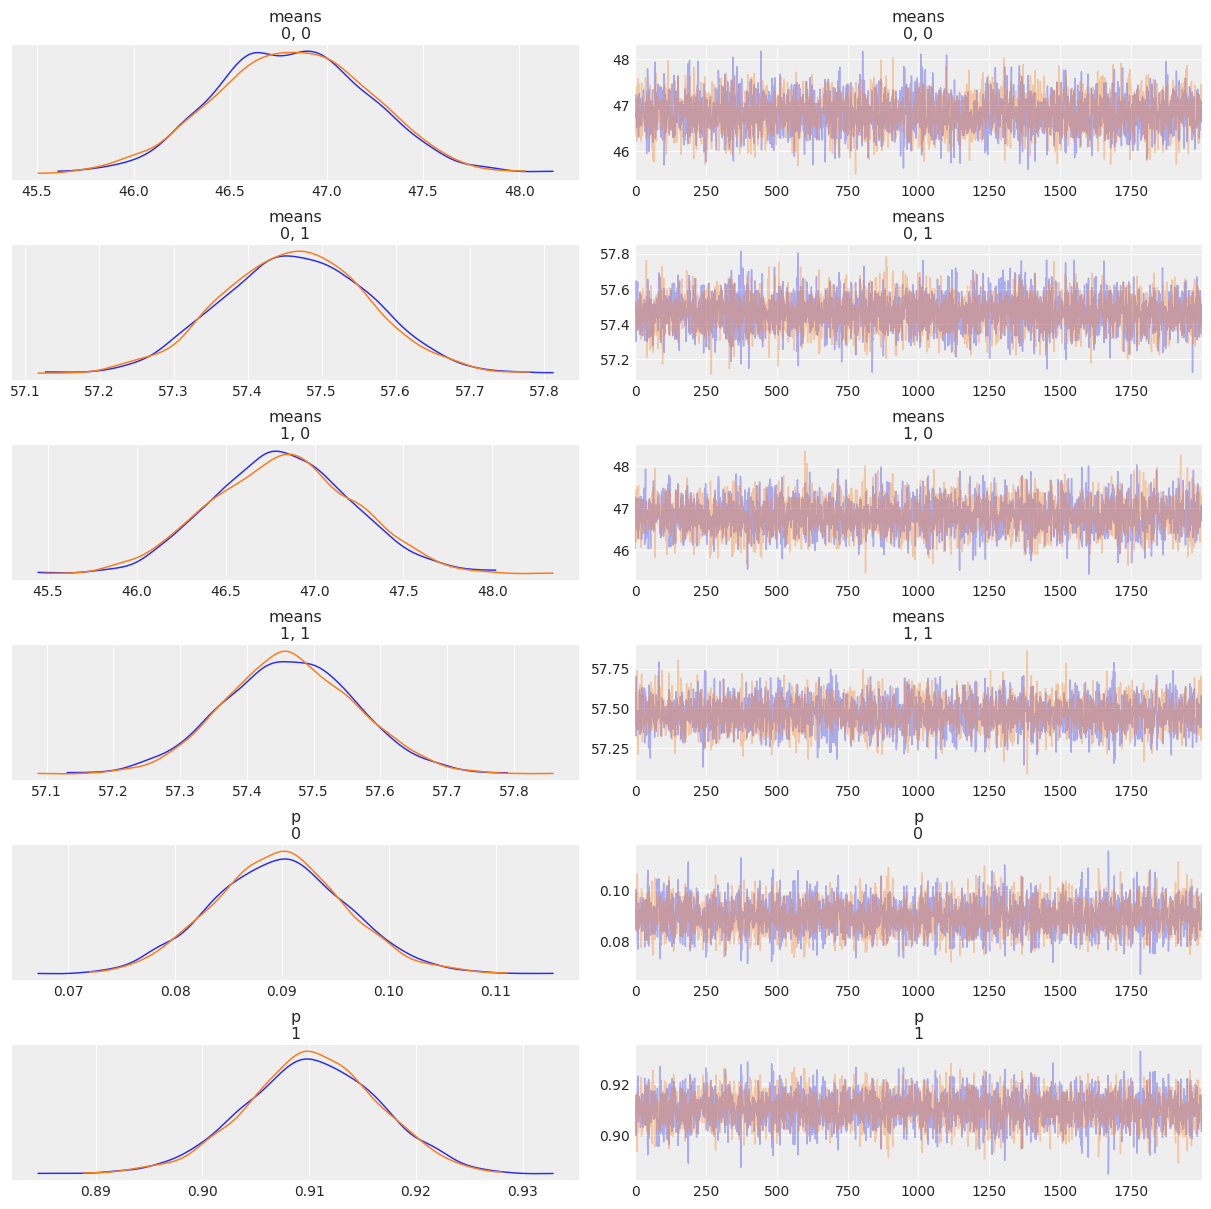

In [21]:
varnames = ['means', 'p']
az.plot_trace(mcmc2, varnames, compact=False)

In [22]:
# instead of a potential we can use an ordered transformation
# transform=pm.distributions.transforms.ordered

In [23]:
az.summary(mcmc2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"means[0,0]",46.823,0.402,46.108,47.601,0.006,0.004,4707.0,3263.0,1.0
"means[0,1]",57.464,0.099,57.274,57.646,0.001,0.001,5627.0,3227.0,1.0
"means[1,0]",46.822,0.398,46.077,47.548,0.006,0.004,4401.0,2888.0,1.0
"means[1,1]",57.464,0.099,57.280,57.649,0.001,0.001,4593.0,3082.0,1.0
p[0],0.090,0.006,0.078,0.101,0.000,0.000,4095.0,2982.0,1.0
p[1],0.910,0.006,0.899,0.922,0.000,0.000,4095.0,2982.0,1.0
sd,3.649,0.053,3.549,3.746,0.001,0.001,5568.0,3207.0,1.0


## How to choose K

In [24]:
def model(obs=None):
    p = numpyro.sample("p", dist.Dirichlet(concentration=jnp.ones(clusters)))
    c = dist.Categorical(probs=p.squeeze())
    
    mu = jnp.array([.9, 1]) * cs_exp.mean()

    means = numpyro.sample('means', dist.Normal(loc=mu, scale=10), sample_shape=(2,))
    sd = numpyro.sample('sd', dist.HalfNormal(scale=10))
    component_dist = dist.Normal(loc=means, scale=sd)
    
    y = numpyro.sample('y', dist.MixtureSameFamily(mixing_distribution=c, component_distribution=component_dist), obs=obs)
    
kernel = NUTS(model)
mcmc2 = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
mcmc2.run(random.PRNGKey(seed), obs=jnp.expand_dims(jnp.asarray(cs_exp), axis=1))

sample: 100%|████████████████████████████████████████████| 2500/2500 [00:05<00:00, 417.45it/s, 3 steps of size 7.73e-01. acc. prob=0.86]


In [25]:
clusters = [3, 4, 5, 6]

models = []
traces = []
for cluster in clusters:
    def model(obs=None):
        
        p = numpyro.sample("p", dist.Dirichlet(concentration=jnp.ones(cluster)))
        c = dist.Categorical(probs=p.squeeze())
    
        mu = jnp.linspace(cs_exp.min(), cs_exp.max(), cluster)
        means = numpyro.sample('means', 
                               dist.TransformedDistribution(
                                   base_distribution=dist.Normal(loc=mu, scale=10).expand([cluster]), 
                               transforms=OrderedTransform()
                              ))
        print(means)
        sd = numpyro.sample('sd', dist.HalfNormal(scale=10))
        component_dist = dist.Normal(loc=means, scale=sd)
        print(c.probs.shape)
        y = numpyro.sample('y', dist.MixtureSameFamily(mixing_distribution=c, component_distribution=component_dist), obs=obs)
        
    kernel = NUTS(model)
    trace = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
    trace.run(random.PRNGKey(seed), obs=jnp.expand_dims(jnp.asarray(cs_exp), axis=1))
    traces.append(trace)
    models.append(model)

[-1.405282   -1.0672494  -0.89249873]
(3,)
Traced<ConcreteArray([-1.405282   -1.0672494  -0.89249873], dtype=float32)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([-1.405282  , -1.0672494 , -0.89249873], dtype=float32)
       tangent = Traced<ShapedArray(float32[3]):JaxprTrace(level=1/0)>
(3,)


  0%|                                                                                                          | 0/2500 [00:00<?, ?it/s]

Traced<ShapedArray(float32[3])>with<JVPTrace(level=4/1)>
  with primal = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/1)>
       tangent = Traced<ShapedArray(float32[3]):JaxprTrace(level=3/1)>
(3,)


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:08<00:00, 286.52it/s, 63 steps of size 4.23e-02. acc. prob=0.90]


[-1.792481   -0.17571521  0.1223264 ]
(3,)
Traced<ConcreteArray([-1.792481   -0.17571521  0.1223264 ], dtype=float32)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([-1.792481  , -0.17571521,  0.1223264 ], dtype=float32)
       tangent = Traced<ShapedArray(float32[3]):JaxprTrace(level=1/0)>
(3,)


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:03<00:00, 820.09it/s, 15 steps of size 2.43e-01. acc. prob=0.91]


[-1.405282   3.7530613  3.927812   4.386582 ]
(4,)
Traced<ConcreteArray([-1.405282   3.7530613  3.927812   4.386582 ], dtype=float32)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([-1.405282 ,  3.7530613,  3.927812 ,  4.386582 ], dtype=float32)
       tangent = Traced<ShapedArray(float32[4]):JaxprTrace(level=1/0)>
(4,)


  0%|                                                                                                          | 0/2500 [00:00<?, ?it/s]

Traced<ShapedArray(float32[4])>with<JVPTrace(level=4/1)>
  with primal = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=2/1)>
       tangent = Traced<ShapedArray(float32[4]):JaxprTrace(level=3/1)>
(4,)


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:35<00:00, 70.17it/s, 255 steps of size 1.19e-02. acc. prob=0.95]


[-1.792481  -0.5164275 -0.2183859  1.5443151]
(4,)
Traced<ConcreteArray([-1.792481  -0.5164275 -0.2183859  1.5443151], dtype=float32)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([-1.792481 , -0.5164275, -0.2183859,  1.5443151], dtype=float32)
       tangent = Traced<ShapedArray(float32[4]):JaxprTrace(level=1/0)>
(4,)


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:27<00:00, 90.79it/s, 127 steps of size 8.03e-03. acc. prob=0.94]


[0.7935977 1.8328353 4.7855444 4.9249754 5.1354523]
(5,)
Traced<ConcreteArray([0.7935977 1.8328353 4.7855444 4.9249754 5.1354523], dtype=float32)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([0.7935977, 1.8328353, 4.7855444, 4.9249754, 5.1354523], dtype=float32)
       tangent = Traced<ShapedArray(float32[5]):JaxprTrace(level=1/0)>
(5,)


  0%|                                                                                                          | 0/2500 [00:00<?, ?it/s]

Traced<ShapedArray(float32[5])>with<JVPTrace(level=4/1)>
  with primal = Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=2/1)>
       tangent = Traced<ShapedArray(float32[5]):JaxprTrace(level=3/1)>
(5,)


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:17<00:00, 145.12it/s, 31 steps of size 1.21e-01. acc. prob=0.95]


[ 0.9015174  4.3690042  7.8917313  8.105168  13.3667755]
(5,)
Traced<ConcreteArray([ 0.9015174  4.3690042  7.8917313  8.105168  13.3667755], dtype=float32)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([ 0.9015174,  4.3690042,  7.8917313,  8.105168 , 13.3667755],            dtype=float32)
       tangent = Traced<ShapedArray(float32[5]):JaxprTrace(level=1/0)>
(5,)


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:13<00:00, 183.09it/s, 63 steps of size 6.52e-02. acc. prob=0.86]


[0.7935977 1.8328353 7.11053   7.249961  7.460438  8.691059 ]
(6,)
Traced<ConcreteArray([0.7935977 1.8328353 7.11053   7.249961  7.460438  8.691059 ], dtype=float32)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([0.7935977, 1.8328353, 7.11053  , 7.249961 , 7.460438 ,
                             8.691059 ], dtype=float32)
       tangent = Traced<ShapedArray(float32[6]):JaxprTrace(level=1/0)>
(6,)


  0%|                                                                                                          | 0/2500 [00:00<?, ?it/s]

Traced<ShapedArray(float32[6])>with<JVPTrace(level=4/1)>
  with primal = Traced<ShapedArray(float32[6])>with<DynamicJaxprTrace(level=2/1)>
       tangent = Traced<ShapedArray(float32[6]):JaxprTrace(level=3/1)>
(6,)


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:35<00:00, 70.27it/s, 127 steps of size 6.11e-02. acc. prob=0.57]


[ 0.9015174  4.3690042  5.2567453  5.4701824 10.731791  10.875133 ]
(6,)
Traced<ConcreteArray([ 0.9015174  4.3690042  5.2567453  5.4701824 10.731791  10.875133 ], dtype=float32)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([ 0.9015174,  4.3690042,  5.2567453,  5.4701824, 10.731791 ,
                             10.875133 ], dtype=float32)
       tangent = Traced<ShapedArray(float32[6]):JaxprTrace(level=1/0)>
(6,)


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:25<00:00, 97.44it/s, 31 steps of size 1.19e-01. acc. prob=0.92]


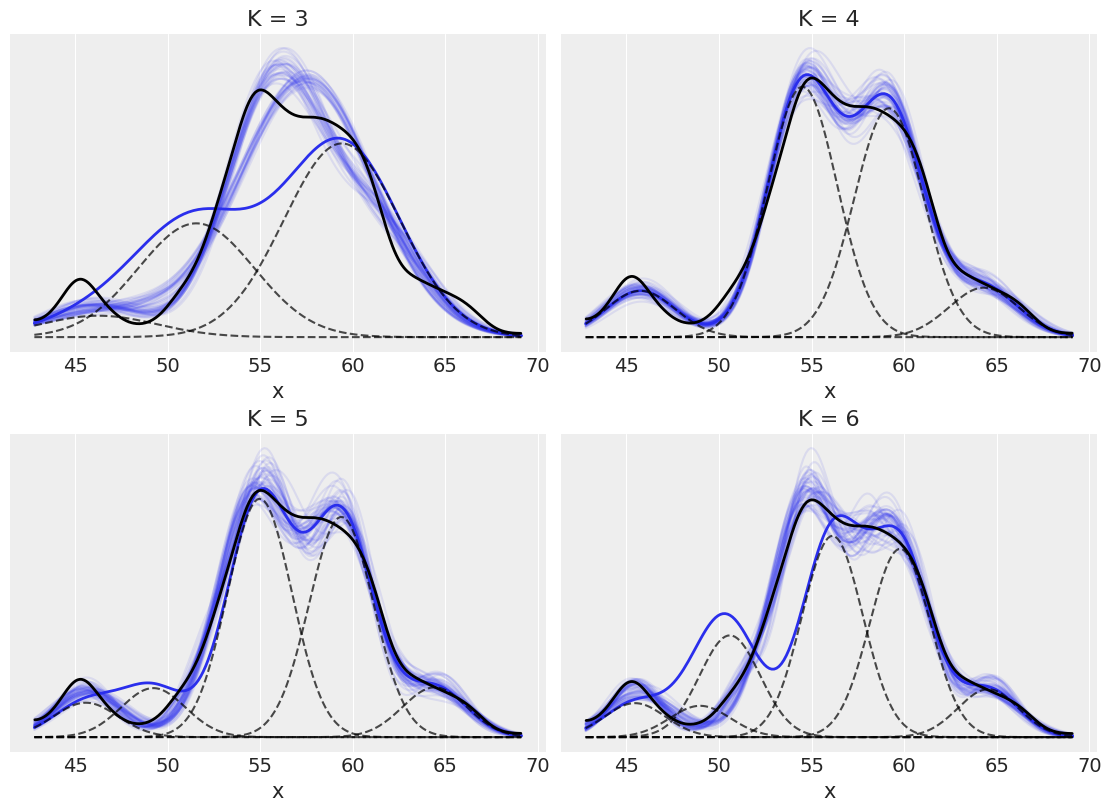

In [26]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
 
ax = list(ax.flat)
x = jnp.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, trace_x in enumerate(traces):
    x_ = jnp.array([x] * clusters[idx]).T
 
    for i in range(50):
        i_ = int(dist.Uniform(low=0, high=len(trace_x.get_samples()['means'])).sample(key=random.PRNGKey(i)))
        means_y = trace_x.get_samples()['means'][i_]
        p_y = trace_x.get_samples()['p'][i_]
        sd = trace_x.get_samples()['sd'][i_]
        distri = dist.Normal(loc=means_y, scale=sd)
        ax[idx].plot(x, jnp.sum(jnp.exp(distri.log_prob(x_)) * p_y, 1), 'C0', alpha=0.1)
 
    means_y = trace_x.get_samples()['means'].mean(0)
    p_y = trace_x.get_samples()['p'].mean(0)
    sd = trace_x.get_samples()['sd'].mean()
    distri = dist.Normal(loc=means_y, scale=sd)
    #stats.norm(means_y, sd)
    ax[idx].plot(x, jnp.sum(jnp.exp(distri.log_prob(x_)) * p_y, 1), 'C0', lw=2)
    ax[idx].plot(x, jnp.exp(distri.log_prob(x_)) * p_y, 'k--', alpha=0.7)
         
    az.plot_kde(cs_exp, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

In [27]:
# prior = Predictive(mcmc_l.sampler.model, num_samples=10)
# prior_p = prior(random.PRNGKey(seed), obs=y_1s)



In [28]:
Predictive(model=traces[0].sampler.model, 
                     posterior_samples=traces[0].get_samples(), 
                     return_sites=['y'])(random.PRNGKey(seed)).values()

Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
(3,)


dict_values([DeviceArray([57.74525 , 50.141926, 53.405487, ..., 57.63712 , 58.24072 ,
             64.50387 ], dtype=float32)])

In [29]:
ppc_mm = [
            Predictive(model=traces[i].sampler.model, 
                     posterior_samples=traces[i].get_samples(), 
                     return_sites=['y'])(random.PRNGKey(seed))
          for i in range(4)]

Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
(3,)
Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
(4,)
Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=1/0)>
(5,)
Traced<ShapedArray(float32[6])>with<DynamicJaxprTrace(level=1/0)>
(6,)


In [30]:
type(ppc_mm)

list

In [31]:
for idx, d_sim in enumerate(list(ppc_mm)):
    print(idx, d_sim['y'])

0 [57.74525  50.141926 53.405487 ... 57.63712  58.24072  64.50387 ]
1 [55.685463 47.6005   49.555256 ... 57.849586 55.612312 61.546535]
2 [54.532833 46.843277 54.844418 ... 54.875175 53.33296  59.637592]
3 [55.4144   41.105106 53.29952  ... 53.94297  52.922012 60.480656]


In [32]:
jnp.expand_dims(d_sim['y'][:100].T, axis=1).shape

(100, 1)

In [34]:
# iqr(d_sim['y'][:100].T, 0)

In [35]:
# ppc_mm = [pm.sample_posterior_predictive(traces[i], 1000, models[i])
#           for i in range(4)]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.

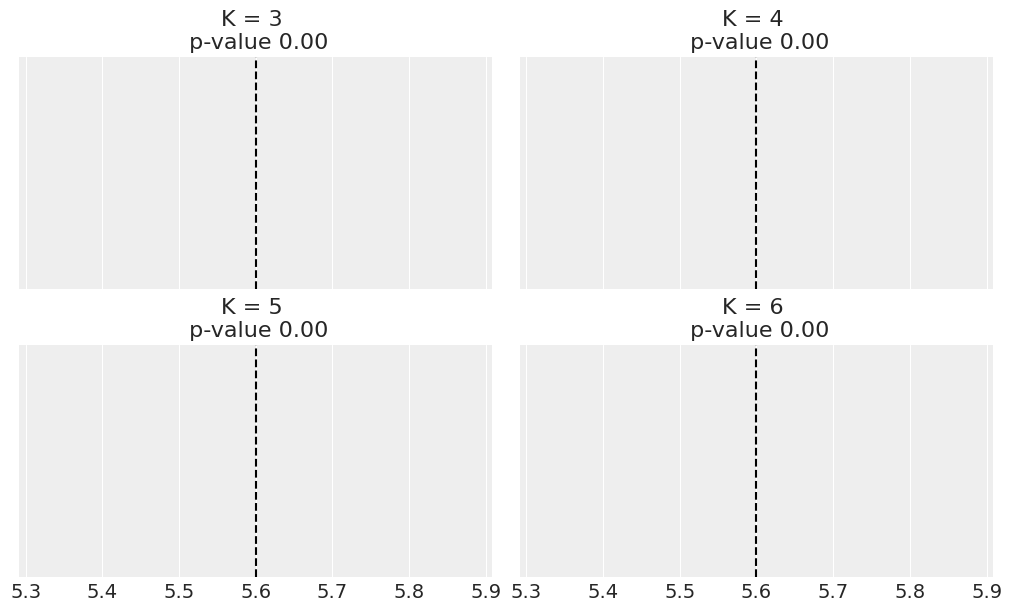

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
ax = list(ax.flat)
def iqr(x, a=0):
    return jnp.subtract(*jnp.percentile(jnp.asarray(x), [75, 25], axis=a))

T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    ds = jnp.expand_dims(d_sim['y'][:100], axis=1)
    T_sim = iqr(ds.T, 0)
    print(T_sim)
    p_value = jnp.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])

In [37]:
comp = az.compare(dict(zip(clusters, traces)), ic="waic", method='BB-pseudo-BMA')
comp

[5.2118061e+01 7.1559749e+20 8.0297345e+20 8.2045797e+20 2.1260502e+32
 1.1329012e+34]
(6,)
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
(3,)
[5.2118061e+01 7.1559749e+20 8.0297345e+20 8.2045797e+20 2.1260502e+32
 1.1329012e+34]
(6,)
Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
(4,)
[5.2118061e+01 7.1559749e+20 8.0297345e+20 8.2045797e+20 2.1260502e+32
 1.1329012e+34]
(6,)
Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=1/0)>
(5,)
[5.2118061e+01 7.1559749e+20 8.0297345e+20 8.2045797e+20 2.1260502e+32
 1.1329012e+34]
(6,)
Traced<ShapedArray(float32[6])>with<DynamicJaxprTrace(level=1/0)>
(6,)


See http://arxiv.org/abs/1507.04544 for details


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
6,0,-5135.310869,15.798141,0.000000,7.039205e-01,32.746687,0.000000,True,log
5,1,-5136.615405,12.786784,1.304536,2.390853e-01,31.524217,1.300529,False,log
4,2,-5139.413207,7.432724,4.102338,5.699420e-02,31.128302,2.552043,False,log
3,3,-5203.690167,17.401520,68.379299,2.699810e-21,31.289554,9.751138,False,log


In [38]:
# Broken. TODO, fix error relating to this.
# az.plot_compare(comp)

## Non-finite mixture model

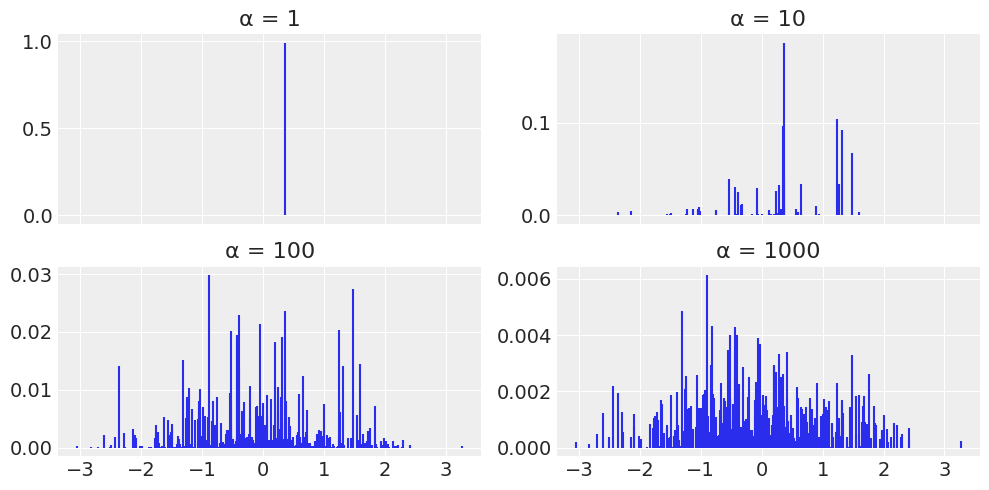

In [39]:
def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP
    
    Parameters
    ----------
    α : float
        concentration parameter
    H : `numpyro` distribution
        base distribution
    K : int
        number of components
    
    Returns
    -------
    locs : array
        locations
    w : array
        probabilities
    """
    
#     βs = stats.beta.rvs(1, α, size=K)
    βs = dist.Beta(concentration1=1, concentration0=α).sample(random.PRNGKey(1), (K,))
    w = jnp.empty(K)
    w = βs * jnp.concatenate((jnp.array([1.]), jnp.cumprod(1 - βs[:-1])))
    locs = H.sample(random.PRNGKey(1), (K,))
    return locs, w

# Parameters DP
K = 500
H = dist.Normal()
alphas = [1, 10, 100, 1000]

# plot
_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = list(ax.flat)
for idx, α in enumerate(alphas):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0')
    ax[idx].set_title('α = {}'.format(α))

plt.tight_layout()

([], [])

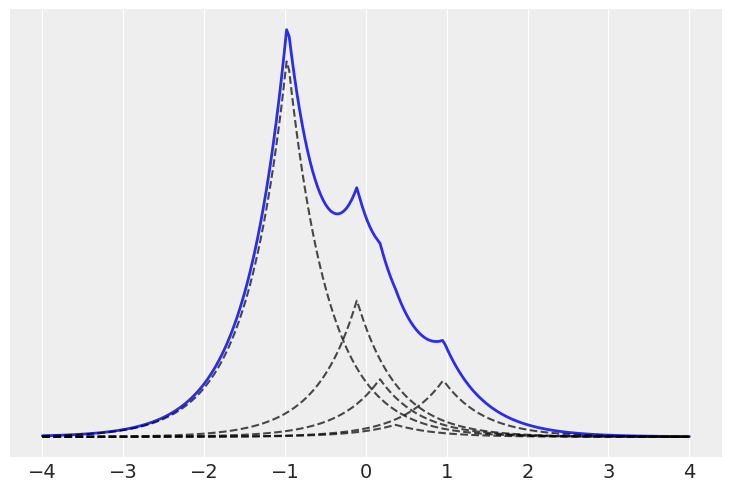

In [40]:
α = 10
H = dist.Normal()
K = 5

x = jnp.linspace(-4, 4, 250)
x_ = jnp.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)

# dist = stats.laplace(locs, 0.5)
distri = dist.Laplace(loc=locs, scale=0.5)
plt.plot(x, jnp.sum(jnp.exp(distri.log_prob(x_)) * w, 1), 'C0', lw=2)
plt.plot(x, jnp.exp(distri.log_prob(x_)) * w, 'k--', alpha=0.7)
plt.yticks([])

In [41]:
K = 20

def stick_breaking(α, K):
    β = numpyro.sample('β', dist.Beta(concentration1=1., concentration0=α), sample_shape=(K,))
    w = β * jnp.concatenate([jnp.array([1.]), jnp.cumprod(1. - β)[:-1]])
#     β = pm.Beta('β', 1., α, shape=K)
#     w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])

    return w

In [42]:
def model(obs=None):
    α = numpyro.sample('α', dist.Gamma(concentration=1, rate=1.))
    w = numpyro.deterministic('w', stick_breaking(α, K))
                       
#     p = numpyro.sample("p", dist.Dirichlet(concentration=jnp.ones(clusters)))
    c = dist.Categorical(probs=w.squeeze())
    
    mu = jnp.linspace(cs_exp.min(), cs_exp.max(), K)

    means = numpyro.sample('means', dist.Normal(loc=mu, scale=10), sample_shape=(K,))
                       
    sd = numpyro.sample('sd', dist.HalfNormal(scale=10))
                       
    component_dist = dist.Normal(loc=means, scale=sd)
    
    obss = numpyro.sample('obss', dist.MixtureSameFamily(mixing_distribution=c, component_distribution=component_dist), obs=obs)
    
kernel = NUTS(model, target_accept_prob=0.85)
mcmc3 = MCMC(kernel, num_warmup=50, num_samples=50, num_chains=2, chain_method='sequential')
mcmc3.run(random.PRNGKey(seed), obs=jnp.expand_dims(jnp.asarray(cs_exp.values), axis=1))

sample: 100%|████████████████████████████████████████████| 100/100 [04:46<00:00,  2.86s/it, 1023 steps of size 1.83e-03. acc. prob=0.97]


In [43]:
# with pm.Model() as model:
#     α = pm.Gamma('α', 1, 1.)
#     w = pm.Deterministic('w', stick_breaking(α, K))
#     means = pm.Normal('means',
#                       mu=np.linspace(cs_exp.min(), cs_exp.max(), K),
#                       sd=10, shape=K)
    
#     sd = pm.HalfNormal('sd', sd=10, shape=K)
#     obs = pm.NormalMixture('obs', w, means, sd=sd, observed=cs_exp.values)
#     trace = pm.sample(1000, tune=2000, nuts_kwargs={'target_accept':0.85})

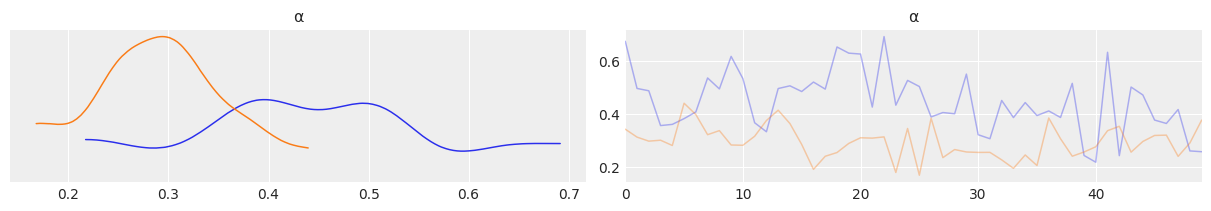

In [44]:
az.plot_trace(mcmc3, var_names=['α'], divergences=False, compact=False);

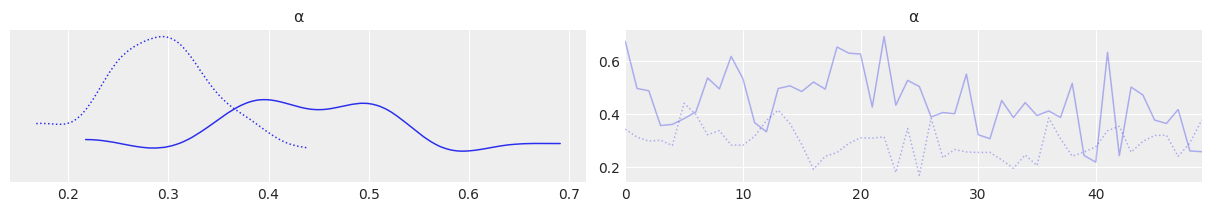

In [45]:
az.plot_trace(mcmc3, var_names=['α'], divergences=False);

Text(0, 0.5, 'Average weight')

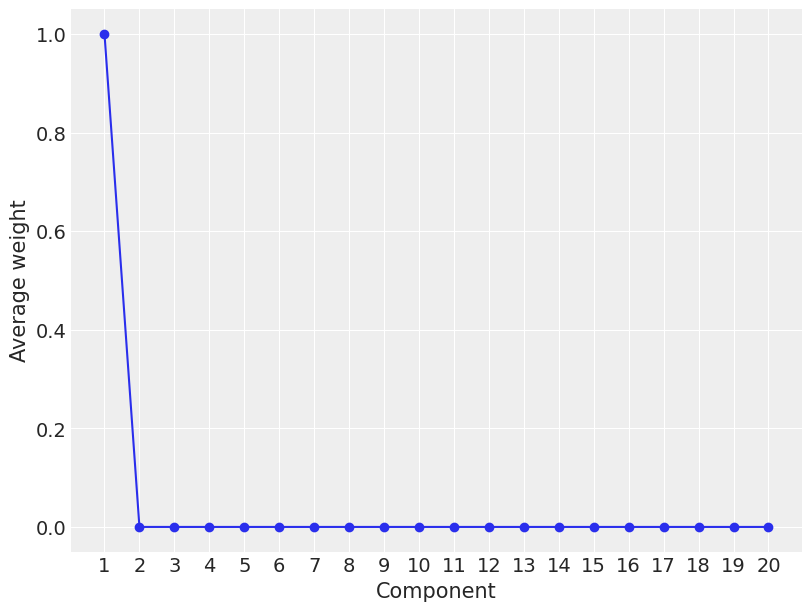

In [46]:
plt.figure(figsize=(8, 6))
plot_w = jnp.arange(K)
plt.plot(plot_w, mcmc3.get_samples()['w'].mean(0), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')

In [54]:
trace.get_samples()['means']

DeviceArray([[45.43555 , 45.76748 , 45.818993, 54.50315 , 59.173943,
              64.33026 ],
             [45.743027, 45.879845, 46.071526, 54.450314, 59.080513,
              64.30733 ],
             [45.39138 , 45.724678, 45.91162 , 54.48335 , 59.17437 ,
              64.41409 ],
             ...,
             [45.498985, 51.297474, 54.39981 , 57.54888 , 60.524788,
              64.93046 ],
             [45.635292, 51.222794, 54.21004 , 57.125477, 60.29111 ,
              64.93555 ],
             [45.34042 , 51.778076, 54.736847, 57.581596, 60.05674 ,
              64.63671 ]], dtype=float32)

In [74]:
mcmc3.get_samples()['means'].shape

(100, 20, 20)

In [78]:
jnp.expand_dims(mcmc3.get_samples()['means'], axis=0).shape

(1, 100, 20, 20)

In [57]:
mcmc3.get_samples()['means'][:, jnp.newaxis, :].shape

(100, 1, 20, 20)

In [58]:
mcmc3.get_samples()['sd'].shape, jnp.expand_dims(mcmc3.get_samples()['sd'], axis=1).shape

((100,), (100, 1))

In [65]:
mcmc3.get_samples()['w'][:, jnp.newaxis, :].shape, jnp.expand_dims(mcmc3.get_samples()['w'], axis=2).shape

((100, 1, 20), (100, 20, 1))

In [73]:
dist.Normal(
        loc=jnp.expand_dims(mcmc3.get_samples()['means'], axis=0), 
        scale=jnp.expand_dims(mcmc3.get_samples()['sd'], axis=0)
    )

ValueError: Incompatible shapes for broadcasting: ((1, 1, 1, 1), (1, 100, 20, 20), (1, 1, 1, 100))

In [72]:
x_plot = jnp.linspace(cs.exp.min()-1, cs.exp.max()+1, 200)

post_pdf_contribs = jnp.exp(
    dist.Normal(
        loc=jnp.expand_dims(mcmc3.get_samples()['means'], axis=0), 
        scale=jnp.expand_dims(mcmc3.get_samples()['sd'], axis=0)
    ).log_prob(jnp.atleast_3d(x_plot))
    ) # [:, jnp.newaxis, :]
post_pdfs = (jnp.expand_dims(mcmc3.get_samples()['w'], axis=0) * post_pdf_contribs).sum(axis=-1)

ValueError: Incompatible shapes for broadcasting: ((1, 1, 1, 1), (1, 100, 20, 20), (1, 1, 1, 100))

In [71]:
import numpy as np
x_plot = np.linspace(cs.exp.min()-1, cs.exp.max()+1, 200)
import scipy
post_pdf_contribs = scipy.stats.norm.pdf(np.atleast_3d(x_plot),
                                   mcmc3.get_samples()['means'][:, np.newaxis, :],
                                   mcmc3.get_samples()['sd'][:, np.newaxis, :])
post_pdfs = (mcmc3.get_samples()['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(cs_exp.values, bins=25, density=True, alpha=0.5)
plt.plot(x_plot, post_pdfs[::100].T, c='0.5')
plt.plot(x_plot, post_pdfs.mean(axis=0), c='k')

plt.xlabel('x')
plt.yticks([])

In [ ]:
## Exercises
# clusters = 3
# n_cluster = [200, 150, 170]
# n_total = sum(n_cluster)
# means = [5, 0, -3]
# std_devs = [2, 2, 2]
# mix = np.random.normal(jnp.repeat(means, n_cluster),
# np.repeat(std_devs, n_cluster))
# az.plot_kde(np.array(mix));